In [1]:
import os
print(os.listdir('flowers/'))

['dandelion', 'daisy', 'flowers', 'tulip', 'rose', 'sunflower']


In [2]:
FLOWER_DAISY_DIR='flowers/daisy/'
FLOWER_SUNFLOWER_DIR='flowers/sunflower/'
FLOWER_TULIP_DIR='flowers/tulip/'
FLOWER_DANDELION_DIR='flowers/dandelion/'
FLOWER_ROSE_DIR='flowers/rose/'

In [3]:
X=[]
Z=[]
IMG_SIZE=150

In [4]:
import cv2
import numpy as np
from tqdm import tqdm

In [5]:
def make_train_data(flower_type,DIR):
    for img in tqdm(os.listdir(DIR)):
        label=flower_type
        path=os.path.join(DIR,img)
        img=cv2.imread(path)
        img=cv2.resize(img,(IMG_SIZE,IMG_SIZE))
        X.append(np.array(img))
        Z.append(str(label))

In [6]:
make_train_data('Daisy',FLOWER_DAISY_DIR)
print(len(X))

100%|██████████| 769/769 [00:10<00:00, 74.47it/s]

769


In [7]:
make_train_data('Sunflower',FLOWER_SUNFLOWER_DIR)
print(len(X))

100%|██████████| 734/734 [00:10<00:00, 68.13it/s]

1503


In [8]:
make_train_data('Tulip',FLOWER_TULIP_DIR)
print(len(X))

100%|██████████| 984/984 [00:12<00:00, 81.71it/s]

2487


In [9]:
make_train_data('Dandelion',FLOWER_DANDELION_DIR)
print(len(X))

 13%|█▎        | 142/1055 [00:02<00:12, 75.30it/s]


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/imgproc/src/resize.cpp:4044: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


In [10]:
make_train_data('Rose',FLOWER_ROSE_DIR)
print(len(X))

100%|██████████| 784/784 [00:07<00:00, 98.20it/s] 

3413


In [11]:
from collections import Counter
Counter(Z)

Counter({'Daisy': 769,
         'Sunflower': 734,
         'Tulip': 984,
         'Dandelion': 142,
         'Rose': 784})

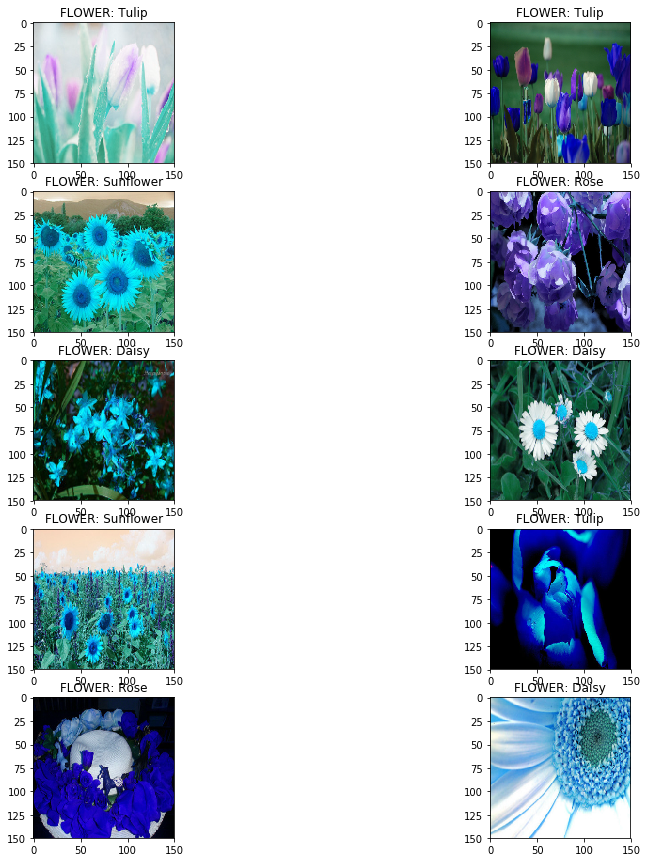

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
import random as rn

fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)
for i in range(5):
    for j in range(2):
        l=rn.randint(0,len(Z))
        ax[i,j].imshow(X[l])
        ax[i,j].set_title('FLOWER: '+Z[l])
plt.show()

In [13]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
Y=le.fit_transform(Z)
print(Y)

[0 0 0 ... 2 2 2]


In [14]:
from keras.utils import to_categorical
Y=to_categorical(Y,5)

Using TensorFlow backend.


In [15]:
X=np.array(X)
X=X/255

In [16]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(X,Y,test_size=0.25,random_state=42)
np.random.seed(42)
rn.seed(42)

In [17]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D

model=Sequential()
model.add(Conv2D(filters=32,kernel_size=(5,5),padding='Same',activation='relu',input_shape=(150,150,3)))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=96,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

model.add(Conv2D(filters=96,kernel_size=(3,3),padding='Same',activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))

Instructions for updating:
Colocations handled automatically by placer.


In [18]:
from keras.layers import Flatten, Activation, Dense
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(5,activation='softmax'))

In [19]:
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator

red_lr=ReduceLROnPlateau(monitor='val_acc',patient=3,verbose=1,factor=0.1)
datagen= ImageDataGenerator(featurewise_center=False,samplewise_center=False,featurewise_std_normalization=False,
                            samplewise_std_normalization=False,zca_whitening=False,rotation_range=10,zoom_range=0.1,
                            width_shift_range=0.2,height_shift_range=0.2,horizontal_flip=True,vertical_flip=False)
datagen.fit(x_train)

In [20]:
from keras.optimizers import adam
model.compile(optimizer=adam(lr=0.001),loss='categorical_crossentropy',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 150, 150, 32)      2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 75, 75, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 75, 75, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 37, 37, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 37, 37, 96)        55392     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 18, 18, 96)       

In [21]:
batch_size=128
epochs=50
history=model.fit_generator(datagen.flow(x_train,y_train,batch_size=batch_size),epochs=epochs,
                           validation_data=(x_test,y_test),verbose=1,
                            steps_per_epoch=x_train.shape[0]//batch_size)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
19/19 [==============================] - 229s 12s/step - loss: 1.5360 - accuracy: 0.3089 - val_loss: 1.2854 - val_accuracy: 0.4239
Epoch 2/50
19/19 [==============================] - 218s 11s/step - loss: 1.2215 - accuracy: 0.4665 - val_loss: 1.1068 - val_accuracy: 0.5785
Epoch 3/50
19/19 [==============================] - 216s 11s/step - loss: 1.0833 - accuracy: 0.5705 - val_loss: 1.0547 - val_accuracy: 0.5738
Epoch 4/50
19/19 [==============================] - 216s 11s/step - loss: 1.0059 - accuracy: 0.5862 - val_loss: 0.9432 - val_accuracy: 0.6159
Epoch 5/50
19/19 [==============================] - 216s 11s/step - loss: 1.0210 - accuracy: 0.5806 - val_loss: 0.9958 - val_accuracy: 0.5960
Epoch 6/50
19/19 [==============================] - 215s 11s/step - loss: 0.9936 - accuracy: 0.6006 - val_loss: 0.9052 - val_accuracy: 0.6499
Epoch 7/50
19/19 [==============================] - 215s 11s/step - loss: 0.9286 - accuracy: 0.6358 

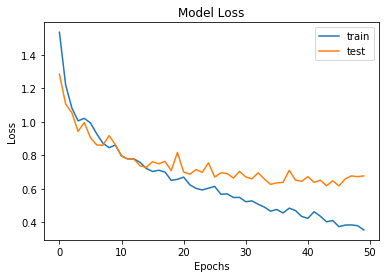

In [22]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

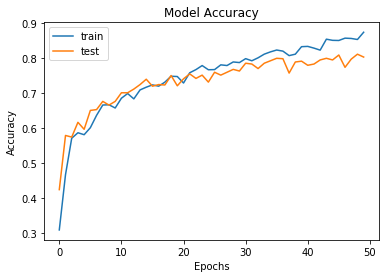

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'test'])
plt.show()

In [27]:
pred=model.predict(x_test)
pred_digits=np.argmax(pred,axis=1)

In [28]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(y_test)):
    if(np.argmax(y_test[i])==pred_digits[i]):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(y_test)):
    if(not np.argmax(y_test[i])==pred_digits[i]):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

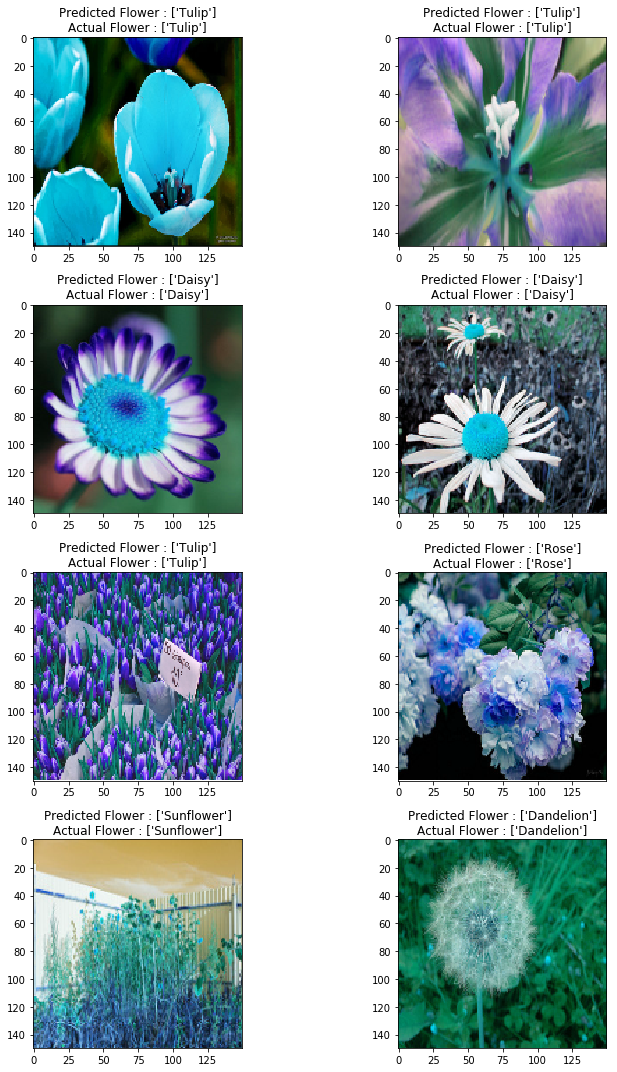

In [29]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[prop_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[prop_class[count]]]))+"\n"+
                          "Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[prop_class[count]]])])))
        plt.tight_layout()
        count+=1

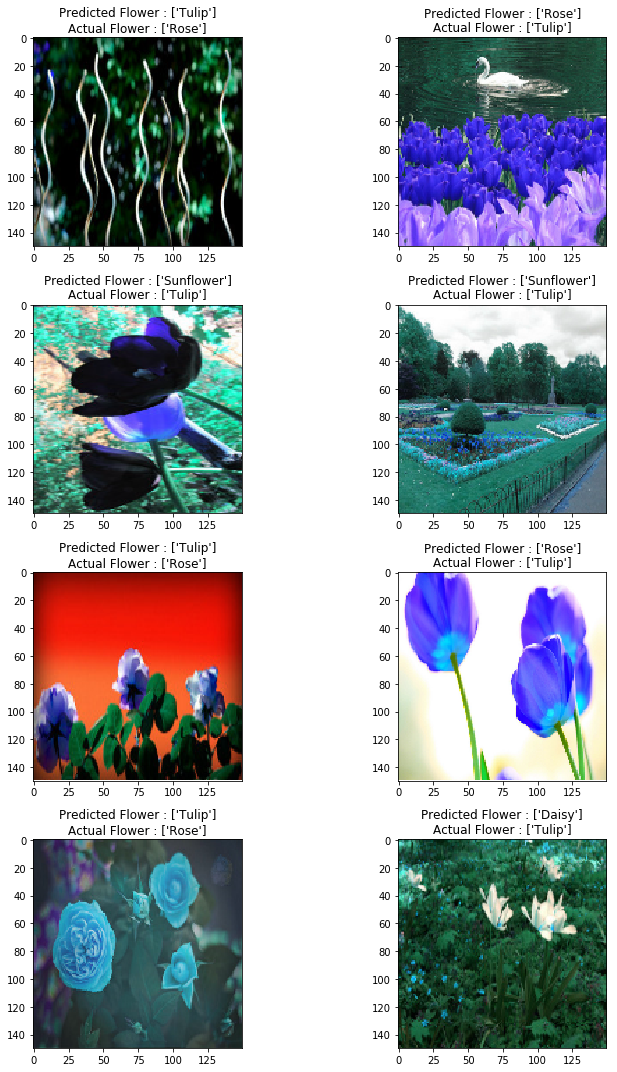

In [30]:
count=0
fig,ax=plt.subplots(4,2)
fig.set_size_inches(15,15)
for i in range (4):
    for j in range (2):
        ax[i,j].imshow(x_test[mis_class[count]])
        ax[i,j].set_title("Predicted Flower : "+str(le.inverse_transform([pred_digits[mis_class[count]]]))+
                          "\n"+"Actual Flower : "+str(le.inverse_transform([np.argmax([y_test[mis_class[count]]])])))
        plt.tight_layout()
        count+=1